## Deep Learning Model for Time Series Forecast

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.layers import GRU, Embedding, LSTM

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
import yfinance as yf

In [3]:
aapl = yf.download('BTC-USD','2019-01-01')
data = pd.DataFrame(aapl['Close'].copy()).reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Close
852,2021-05-06,56396.515625
853,2021-05-07,57356.402344
854,2021-05-08,58803.777344
855,2021-05-09,58232.316406
856,2021-05-10,58496.128906


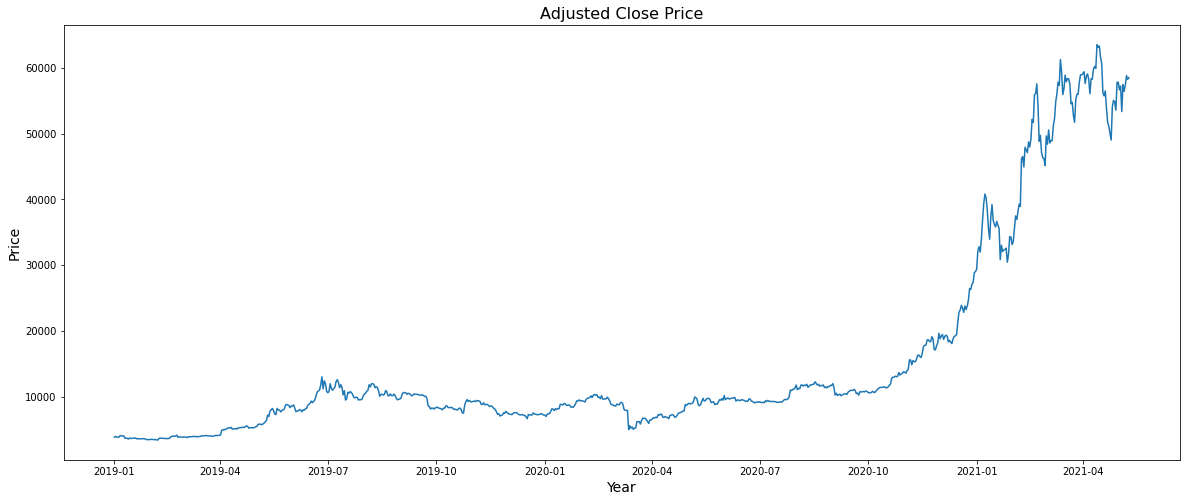

In [4]:
# Plot the close price of the AAPL
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(data['Date'], data['Close'])
plt.title("Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year',  fontsize=14) 
plt.show()

In [5]:
from forecasttime.model_eval import *
from forecasttime.utils import *
from forecasttime.model_dev import *

Dataframe to array sequence

In [6]:
help(train_test_split)

Help on function train_test_split in module forecasttime.utils:

train_test_split(dataset, test=0.3)
    split the dataframe into train and test set
    
    Parameters:
        dataset: dataframe name
        test: 
            if test < 1: the ratio of the data for test
            if test >= 1: the number of observations for test 
    Return:
        two dataframes: one for train and one for test



In [7]:
series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv', header=0, index_col=0)
data = series.values

In [8]:
# data split
n_test = 12
# define config
config = [24, 500, 100, 100]
# grid search
scores = repeat_evaluate('mlp',data, config, n_test)

NameError: name 'train_test_split' is not defined

In [77]:
# summarize scores
summarize_scores('mlp', scores)

In [78]:
data_ts=date_features(data, 'Date')
data_ts

,Date,Close,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2019-01-01,3843.520020,1,1,1,2019,1,1,1
1,2019-01-02,3943.409424,2,1,1,2019,2,2,1
2,2019-01-03,3836.741211,3,1,1,2019,3,3,1
3,2019-01-04,3857.717529,4,1,1,2019,4,4,1
4,2019-01-05,3845.194580,5,1,1,2019,5,5,1
...,...,...,...,...,...,...,...,...,...
850,2021-05-04,53333.539062,1,2,5,2021,124,4,18
851,2021-05-05,57424.007812,2,2,5,2021,125,5,18
852,2021-05-06,56396.515625,3,2,5,2021,126,6,18
853,2021-05-07,57356.402344,4,2,5,2021,127,7,18


In [80]:
data_ts.tail(10)

,Date,Close,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
845,2021-04-29,53555.109375,3,2,4,2021,119,29,17
846,2021-04-30,57750.175781,4,2,4,2021,120,30,17
847,2021-05-01,57828.050781,5,2,5,2021,121,1,17
848,2021-05-02,56631.078125,6,2,5,2021,122,2,17
849,2021-05-03,57200.292969,0,2,5,2021,123,3,18
850,2021-05-04,53333.539062,1,2,5,2021,124,4,18
851,2021-05-05,57424.007812,2,2,5,2021,125,5,18
852,2021-05-06,56396.515625,3,2,5,2021,126,6,18
853,2021-05-07,57356.402344,4,2,5,2021,127,7,18
854,2021-05-09,58703.011719,6,2,5,2021,129,9,18


In [79]:
data_ts.dayofweek.value_counts()

2    123
3    123
6    123
1    122
5    122
0    121
4    121
Name: dayofweek, dtype: int64

In [44]:
train_df, test_df = divideTrainTest(data, 50)

In [45]:
print("train_df length:", len(train_df))
print("test_df length", len(test_df))

train_df length: 805
test_df length 50


## Machine Learning Models for Time Series Forecast

In [7]:
df2_ds = df2[['date','sale_dollars']] # selecting the needed columns

In [8]:
df2_ds=df2_ds.sort_index(axis=0)

In [9]:
df2_ds.tail(5)

,date,sale_dollars
50522,2019-12-09,1379.88
50523,2019-11-25,148.50
50524,2019-10-24,119.28
50525,2019-10-17,119.28
50526,2019-10-21,279.00


In [10]:
aggregated=df2_ds.groupby('date',as_index=True).sum()

In [11]:
print(min(aggregated.index))
print(max(aggregated.index))

2018-01-03
2020-07-30


In [12]:
aggregated.index=pd.to_datetime(aggregated.index)

## Feature creation

In [54]:
def create_features(df, datetimeIndex_col):
    """
    Creates time series features from datetime index
    """
    df[datetimeIndex_col]
    df['dayofweek'] = df[datetimeIndex_col].dt.dayofweek
    df['quarter'] = df[datetimeIndex_col].dt.quarter
    df['month'] = df[datetimeIndex_col].dt.month
    df['year'] = df[datetimeIndex_col].dt.year
    df['dayofyear'] = df[datetimeIndex_col].dt.dayofyear
    df['dayofmonth'] = df[datetimeIndex_col].dt.day
    df['weekofyear'] = df[datetimeIndex_col].dt.weekofyear
    df['weekofmonth'] = df[datetimeIndex_col].dt.week
    df['covid_flag'] = pd.Series(np.where(df[datetimeIndex_col] >= np.datetime64('2020-03-03'), 1, 0), index=df.index) #flag for COVID-19
    #df['rolling_mean_7'] = df['sale_dollars'].shift(7).rolling(window=7).mean()
    #df['lag_7'] = df['sale_dollars'].shift(7)
    #df['lag_15']=df['sale_dollars'].shift(15)
    #df['lag_last_year']=df['sale_dollars'].shift(52).rolling(window=15).mean()
  
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','flag','sale_dollars']]
    X.index=df.index
    return X

In [14]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

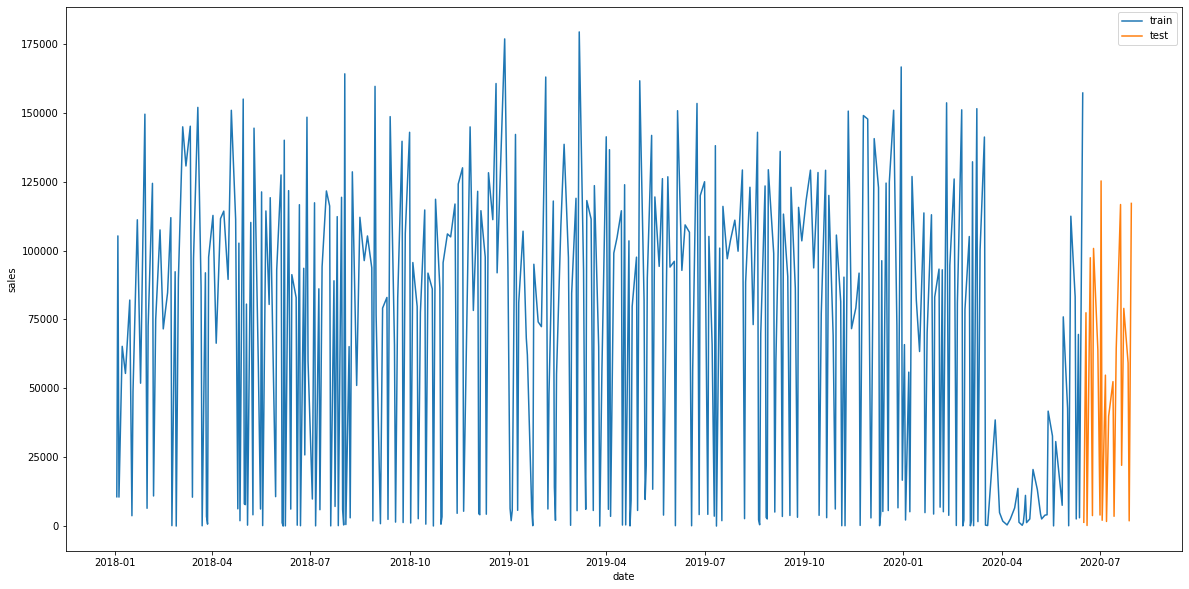

In [15]:
aggregated=create_features(aggregated)
train, test = split_data(aggregated, '2020-06-15') # splitting the data for training before 15th June

plt.figure(figsize=(20,10))
plt.xlabel('date')
plt.ylabel('sales')
plt.plot(train.index,train['sale_dollars'],label='train')
plt.plot(test.index,test['sale_dollars'],label='test')
plt.legend()
plt.show()

In [16]:
train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars
date,,,,,,,,,
2018-01-03,2,1,1,2018,3,3,1,0,10639.43
2018-01-04,3,1,1,2018,4,4,1,0,105307.95
2018-01-05,4,1,1,2018,5,5,1,0,10526.40
2018-01-08,0,1,1,2018,8,8,2,0,65236.68
2018-01-11,3,1,1,2018,11,11,2,0,55396.46


## Machine Learning Model Building and Fitting

In [17]:
# import the regression module
from pycaret.regression import *


In [20]:
# initialize setup
reg = setup(data = train, 
             target = 'sale_dollars',
             numeric_imputation = 'mean',
             categorical_features = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear',
                                     'flag']  ,  
                  combine_rare_levels = True, rare_level_threshold = 0.1,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95, 
             silent = True)

,Description,Value
0,session_id,3182
1,Target,sale_dollars
2,Original Data,"(385, 9)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(269, 131)"


model performance metrics: [3 Best metrics to evaluate Regression Model?](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)


In [21]:
# returns best models - takes a little time to run
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,21504.2108,1051079766.3017,31225.3192,0.6262,1.5797,12.1356,0.3770
lightgbm,Light Gradient Boosting Machine,23530.6898,1053519234.9445,31397.5576,0.6237,1.9160,30.8248,0.0440
br,Bayesian Ridge,25976.7987,1189973279.7079,33694.5537,0.5735,2.0393,36.3711,0.0360
huber,Huber Regressor,25446.9844,1214186810.4179,33873.8466,0.5651,1.9078,22.5496,0.0610
gbr,Gradient Boosting Regressor,24489.2749,1235594843.5267,33856.5642,0.5637,1.8871,30.0468,0.0900
ada,AdaBoost Regressor,27229.4143,1217342656.8170,34362.9607,0.5595,2.1435,49.2332,0.0640
par,Passive Aggressive Regressor,28190.7276,1273631792.9609,35064.0011,0.5412,2.1023,43.6284,0.1350
omp,Orthogonal Matching Pursuit,26053.3573,1274602318.7507,34998.0429,0.5398,1.9940,34.5974,0.0240
ridge,Ridge Regression,27439.9328,1324977120.0000,35725.6232,0.5213,2.0258,36.9523,0.0200
et,Extra Trees Regressor,25424.6516,1539396469.7604,37685.0906,0.4545,1.8411,8.9257,0.3850


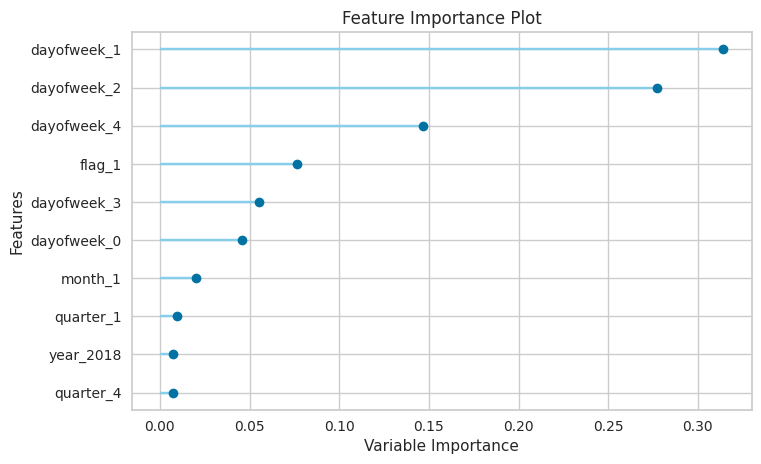

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.05,
                      min_impurity_split=None, min_samples_leaf=6,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=-1, oob_score=False,
                      random_state=3182, verbose=0, warm_start=False)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,19209.4022,981763813.0615,31333.1105,0.6897,1.2062,3.3747


In [35]:
#we create a model using light gbm
rf = create_model('rf')
tuned_rf = tune_model(rf)
plot_model(tuned_rf, plot='feature')
final_rf = finalize_model(tuned_rf)
print(final_rf)
predict_model(final_rf);

In [33]:
test_scored = predict_model(final_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,25572.1463,1107005688.1472,33271.6950,0.6501,1.6629,13.1154


In [34]:
test_scored

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_6,quarter_1,quarter_2,quarter_3,quarter_4,...,weekofyear_51.0,weekofyear_52.0,weekofyear_6.0,weekofyear_7.0,weekofyear_8.0,weekofyear_9.0,weekofyear_others_infrequent,flag_1,sale_dollars,Label
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2206.080078,25721.364972
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,69.360001,-17253.785388
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,711.059998,16244.311185
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1447.140015,19308.681765
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,118956.187500,108000.944832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,126862.437500,85780.567289
112,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5311.080078,38696.864141
113,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,164130.562500,95318.869204
114,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,82974.367188,106868.308149
